In [14]:
# import some packages
from google.colab import drive
drive.mount('/content/gdrive/')
import cv2
from skimage.io import imread               # Module from skimage
import matplotlib.pyplot as plt             # Library used for plotting
import numpy as np                          # Library for array manipulation
from matplotlib import animation            # Module to plot animations
import ipywidgets as widgets                # Library to create widgets
from ipywidgets import interact, interactive, HBox, Layout, VBox # Importing modules and functions
from skimage.filters import gaussian # Module working with a gaussian filter
from skimage import measure
from skimage.morphology import binary_dilation
from skimage.segmentation import watershed

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import os
# your drive may be named "My Drive" instead of MyDrive depending on when your account was made
#if this doesnt work change the path to /content/drive/My\ Drive/
os.listdir('/content/gdrive/MyDrive')  #lists the contents of your google drive
#!ls ./content/gdrive

In [16]:
# help(vid.read)

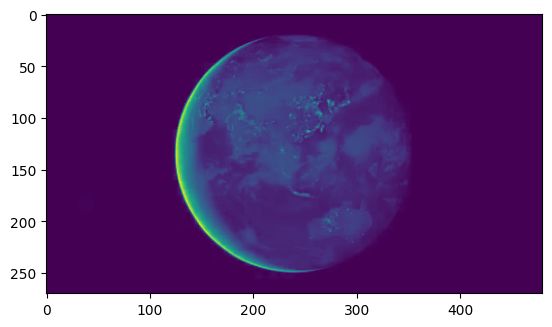

In [27]:
# load the first frame of the video into memory
vid = cv2.VideoCapture('/content/gdrive/MyDrive/file_example_MOV_480_700kB.mov')
worked, img = vid.read()
plt.imshow(img[:,:,0])

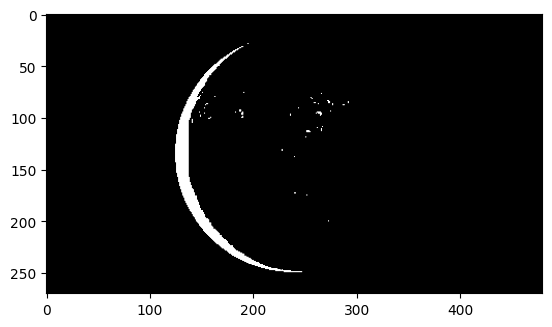

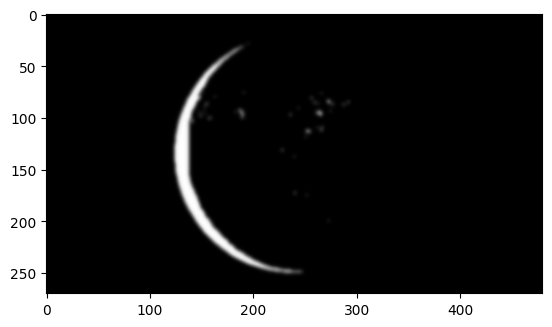

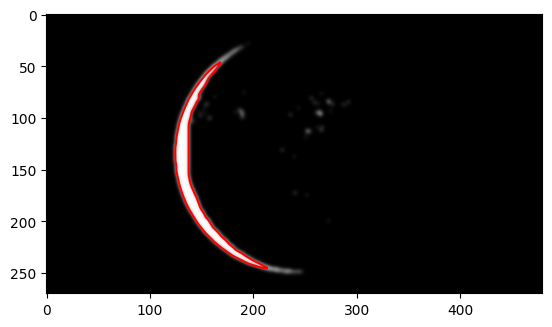

In [28]:
# Thresholding the image
threshold = 100   # Please play  with this threshold
mask_image = np.zeros(img[:,:,0].shape)
mask_image[img[:,:,0]<threshold] = 255
f,ax = plt.subplots()
ax.imshow(mask_image, cmap='Greys')
plt.show()

# Applying a gaussian filter to the image
new_mask = gaussian(mask_image, sigma=2)
f,ax = plt.subplots()
ax.imshow(new_mask, cmap='Greys')
plt.plot()

f,ax = plt.subplots()
contours = measure.find_contours(new_mask, level=125 ) # level is half of 255 (ish). What happens if we change it?
ax.imshow(new_mask, cmap='Greys')
countourlength = np.zeros(len(contours))
for i in range(len(contours)):
  countourlength[i] = len(contours[i])

np.argmax(countourlength)
ax.plot(contours[np.argmax(countourlength)][:,1],contours[np.argmax(countourlength)][:,0],color='r')

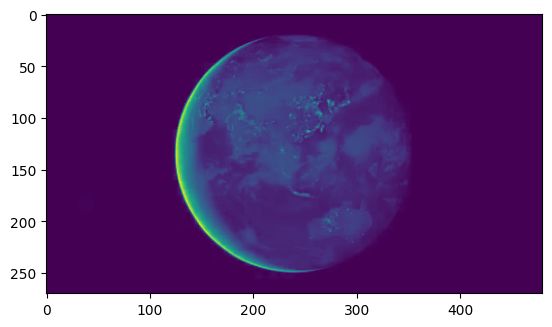

In [29]:
from numpy.lib import npyio
import time
plt.figure()
plt.imshow(img[:,:,0])

train =np.zeros(img.shape)

Nbox = 3
train2 = img[Nbox:-Nbox,Nbox:-Nbox,:]
# train2 = img[Nbox:-Nbox,Nbox:-Nbox,:],[(new_mask.shape[0]-Nbox)*(new_mask.shape[1]-Nbox),3])
targets = np.reshape(new_mask[Nbox:-Nbox,Nbox:-Nbox],[np.prod(new_mask[Nbox:-Nbox,Nbox:-Nbox].shape),1])
targets = targets==255

Nsize = new_mask.shape
for i in range(Nbox*2+1):
  for j in range(Nbox*2+1):
    if (i!=Nbox) or (j!=Nbox):
      train2 = np.append(train2,img[i:Nsize[0]-2*Nbox+i,j:Nsize[1]-2*Nbox+j,:],axis=2)

train2 = np.reshape(train2,((new_mask.shape[0]-2*Nbox)*(new_mask.shape[1]-2*Nbox),(2*Nbox+1)**2*3))

In [30]:
samplerate = 100
train2_sampled = train2[::samplerate,:]
target_sampled = targets[::samplerate]

M = np.linalg.inv(train2_sampled.T @ train2_sampled) @ train2_sampled.T @ target_sampled

train2_reg = np.append(train2_sampled,np.eye(train2_sampled.shape[1]),0)
targets_reg = np.append(target_sampled,np.zeros([train2_sampled.shape[1],1]),0)
M_reg = np.linalg.inv(train2_reg.T @ train2_reg) @ train2_reg.T @ targets_reg

[22.95020599]
[155650.65483407]


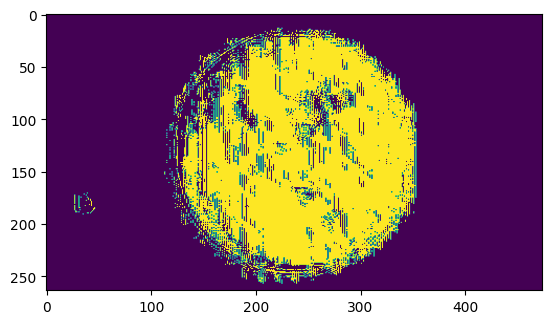

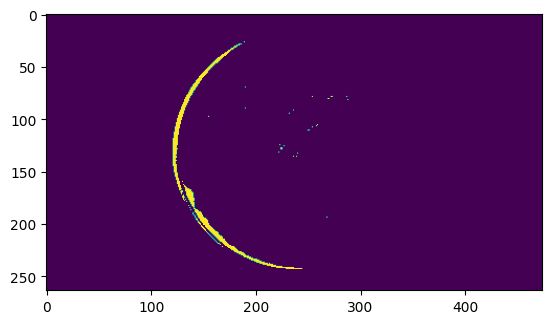

In [31]:
f,ax1 = plt.subplots()
print(max((train2@M_reg)))
Y_guess = (train2@M_reg)>=0.25
img_guess = np.reshape(Y_guess,new_mask[Nbox:-Nbox,Nbox:-Nbox].shape)
ax1.imshow(img_guess)

f,ax2 = plt.subplots()
print(max((train2@M)))
Y_guess = (train2@M) >= 50000
img_guess = np.reshape(Y_guess,new_mask[Nbox:-Nbox,Nbox:-Nbox].shape)
ax2.imshow(img_guess)

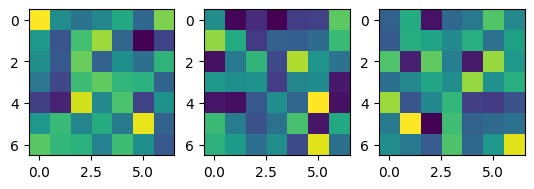

In [32]:
f,ax2 = plt.subplots(1,3)
MFilt = M.reshape(2*Nbox+1,2*Nbox+1,3)
[ax2[i].imshow(MFilt[:,:,i]) for i in range(3)]

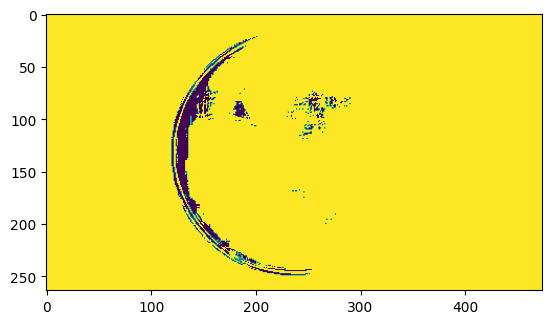

In [33]:
from sklearn import linear_model
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(train2_sampled)
X_scaled = scaler.transform(train2_sampled)

reg = linear_model.BayesianRidge()
reg.fit(X_scaled,np.reshape(target_sampled,target_sampled.shape[0]))

X_scaled = scaler.transform(train2)
img_guess = reg.predict(X_scaled)>.15
f,ax2 = plt.subplots()
ax2.imshow(np.reshape(img_guess,new_mask[Nbox:-Nbox,Nbox:-Nbox].shape))

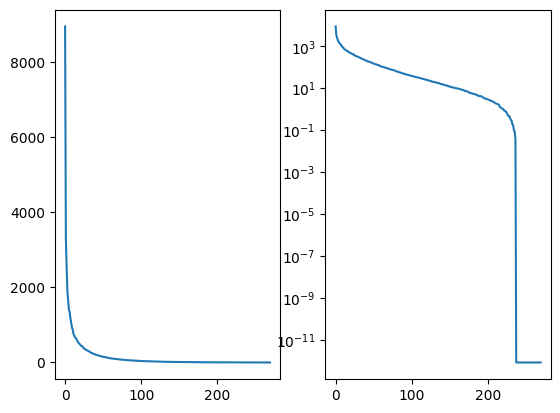

In [34]:
# Singular value decomposition of an image
# Note - try re-zeroing the image first.
img_red = img[:,:,0]
U, Sigma, WT = np.linalg.svd(img_red)

# plot the singular values of the image
fig, axs = plt.subplots(1, 2)
axs[0].plot(Sigma)
axs[1].plot(Sigma)
axs[1].set_yscale('log')

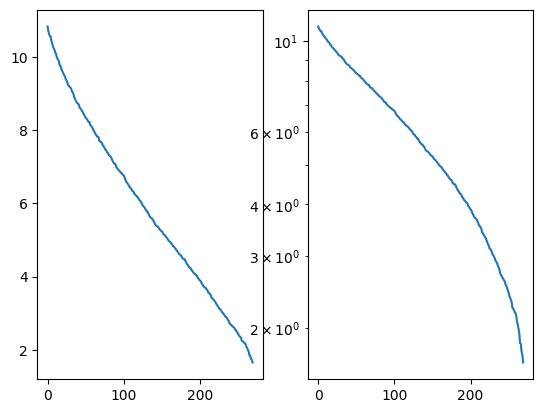

In [35]:
# Do the same for a random image
rand_img = np.random.rand(*img.shape)-0.5
rand_img_red = rand_img[:,:,0]
rand_U, rand_Sigma, rand_WT = np.linalg.svd(rand_img_red)

fig, axs = plt.subplots(1, 2)
axs[0].plot(rand_Sigma)
axs[1].plot(rand_Sigma)
axs[1].set_yscale('log')
# note the more even spread of the singular values

In [ ]:
# help(np.random.rand)

Original size is =388800
Compressed size is =754
Compression rate is =515.6498673740053


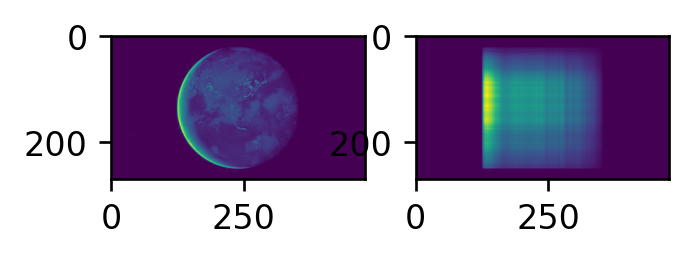

In [36]:
# Lets' see what the images look like when we kust use the firtst few modes.
Nmodes = 1
new_img = U[:,:Nmodes]@np.diag(Sigma[:Nmodes])@WT[:Nmodes,:]
fig, axs = plt.subplots(1, 2,figsize=(3,12),dpi = 240)

# axs[0].imshow(img[300:600,400:600,0])
# axs[1].imshow(new_img[300:600,400:600])
axs[0].imshow(img[:,:,0])
axs[1].imshow(new_img[:,:])

Oldsize = np.prod(img.shape)
Newsize = (np.sum(img.shape)+1)*Nmodes
print('Original size is =' + str(Oldsize))
print('Compressed size is =' + str(Newsize))
print('Compression rate is =' + str(Oldsize/Newsize))


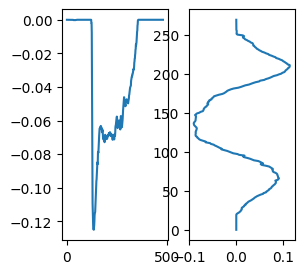

In [37]:
# What do the firs unitary vectors of U and W look like?
fig, axs = plt.subplots(1, 2,figsize=(3,3))
axs[0].plot(WT[0,:])
axs[1].plot(U[:,1],list(range(0,img.shape[0])))

In [39]:
# Let's load all of the frames to make a movie now
vid = cv2.VideoCapture('/content/gdrive/MyDrive/file_example_MOV_480_700kB.mov')
img_vid = [] #np.zeros((100,720,1080,3))
worked, img = vid.read()
while worked:
  img_vid.append(img)
  worked, img = vid.read()

img_vid_np = np.stack(img_vid,axis=0)

In [ ]:
# help(cv2.VideoCapture)
# help(vid.read)

In [40]:
# Let's now watch the animation
TStep = 4
# blit=True re-draws only the parts that have changed
fig,axes = plt.subplots(1,3,dpi=120,figsize=(8,3))
i=0
# Define inital frames
Red = img_vid_np[i*TStep,:,:,0]
im1 = axes[0].imshow(Red,cmap='Reds_r')
Green = img_vid_np[i*TStep,:,:,1]
im2 = axes[1].imshow(Green,cmap='Greens_r')
Blue = img_vid_np[i*TStep,:,:,2]
im3 =  axes[2].imshow(Blue,cmap='Blues_r')
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')

def movieFrame(i):
  Red = img_vid_np[i*TStep,:,:,0]
  Green = img_vid_np[i*TStep,:,:,1]
  Blue = img_vid_np[i*TStep,:,:,2]
  images = [Red,Green,Blue]
  image_handles = [im1,im2,im3]
  for k,image_n in enumerate(images):
    image_handles[k].set_array(images[k])
  return image_handles

plt.close()
anim = animation.FuncAnimation(fig, movieFrame, frames=img_vid_np.shape[0]//TStep, blit=True)
from IPython.display import HTML
HTML(anim.to_html5_video())

In [41]:
# Let's create a new movie that only shows the difference from the median of the image in time.
from scipy.ndimage import gaussian_filter

img_vid2 = img_vid_np[:300,:,:,0].copy()  # I only want the first 300 frames
img_filter = np.zeros(img_vid2.shape)
img_tmp = np.mean(img_vid2,axis=0)

for i in range(img_vid2.shape[0]):
  # img_vid2[i,:,:,j] = np.abs(img_vid_np[i,:,:,:]-img_tmp)
  img_vid2[i,:,:] = np.abs(img_vid2[i,:,:]-img_tmp[:,:])
  img_filter[i,:,:] = gaussian_filter(img_vid2[i,:,:], sigma=5)

In [42]:
from inspect import Parameter
img_tmp = np.median(img_filter,axis=0)
for i in range(img_filter.shape[0]):
  img_filter[i,:,:] = np.abs(img_filter[i,:,:]-img_tmp[:,:])

(-0.5, 479.5, 269.5, -0.5)

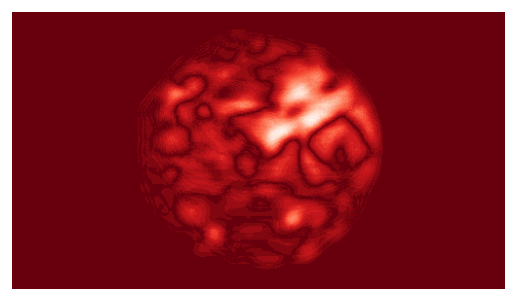

In [43]:
fig,axes = plt.subplots(1,1,dpi=120,figsize=(8,3))
i = 30
Red = img_filter[0,:,:]
im1 = axes.imshow(Red,cmap='Reds_r')
axes.axis('off')

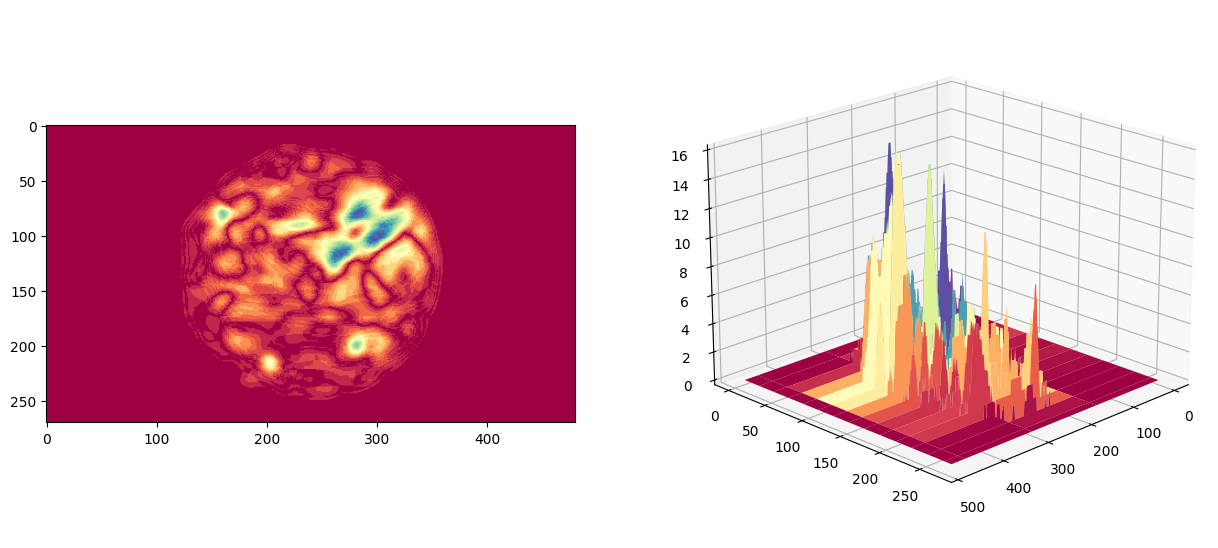

In [53]:


# Plotting the image as the 3d dimension figure.
space0= np.arange(0, img_filter[10,:,:].shape[0], 1)
space1= np.arange(0, img_filter[10,:,:].shape[1], 1)
xx, yy = np.meshgrid(space1,space0)
fig = plt.figure(figsize=(15,7))
# Set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1)
ax.imshow(img_filter[10,:,:],cmap='Spectral') # Reds_r
# Set up the axes for the second plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(xx, yy, img_filter[10,:,:], rstride=20, cstride=150, shade=False, cmap='Spectral')
ax2.view_init(20, 45)
plt.show()

In [ ]:
# help(np.zeros)

interactive(children=(IntSlider(value=50, description='frame_number', max=150, min=-50), Output()), _dom_class…

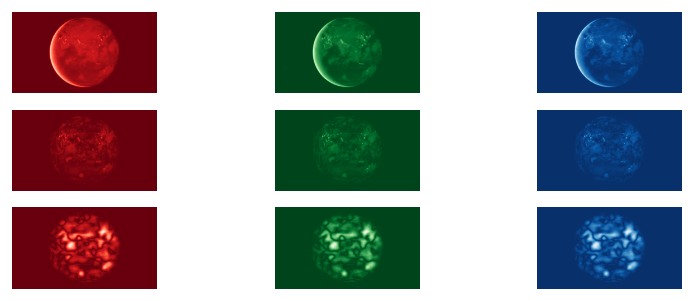

In [60]:
# Now to make a widget to show the difference
# frame_number = 50 #@param range(300)

#!pip install ipywidgets
#!pip install matplotlib
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive

def Wid(frame_number=50):
  fig,axes = plt.subplots(3,3,dpi=120,figsize=(8,3))

  Red = img_vid_np[frame_number,:,:,0]
  im1 = axes[0,0].imshow(Red,cmap='Reds_r')
  Green = img_vid_np[frame_number,:,:,1]
  im2 = axes[0,1].imshow(Green,cmap='Greens_r')
  Blue = img_vid_np[frame_number,:,:,2]
  im3 =  axes[0,2].imshow(Blue,cmap='Blues_r')

  Red = img_vid2[frame_number,:,:]
  im1 = axes[1,0].imshow(Red,cmap='Reds_r')
  Green = img_vid2[frame_number,:,:]
  im2 = axes[1,1].imshow(Green,cmap='Greens_r')
  Blue = img_vid2[frame_number,:,:]
  im3 =  axes[1,2].imshow(Blue,cmap='Blues_r')

  Red = img_filter[frame_number,:,:]
  im1 = axes[2,0].imshow(Red,cmap='Reds_r')
  Green = img_filter[frame_number,:,:]
  im2 = axes[2,1].imshow(Green,cmap='Greens_r')
  Blue = img_filter[frame_number,:,:]
  im3 =  axes[2,2].imshow(Blue,cmap='Blues_r')

  for i in range(3):
    axes[0,i].axis('off')
    axes[1,i].axis('off')
    axes[2,i].axis('off')

w = interactive(Wid, frame_number=50)
display(w)